In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from matplotlib import colors
import deepxde as dde

/tmp/ipykernel_93294/1555995876.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
from problem import Heat_Diffusion_1T
from model import PDE_basis, TrainLS
# from my_utils import plot_2d_tri, plot_domain_2d

In [3]:
data = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b2g1Dul/data-Heat-z3b2g1Dul-1.npz', allow_pickle=True)
my_prob = Heat_Diffusion_1T(case='z3b2g1Dul', data=data)
timestep = 1 / 1000
print(my_prob)

***************************************************
Heat_diffusion_1T (case=z3b2g1Dul):
	x_pde:   	(4229225, 3)
	x_bd:    	(260260, 3)
	x_ic:    	(4225, 3)
	x_test:    	(4229225, 3)
***************************************************


In [21]:
#k = 4225
#basis_num_vec = np.array([k, 2*k, 3*k, 4*k, 5*k, 6*k, 7*k, 8*k])
#shape_vec = np.array([1, 2, 3, 4, 5, 6, 6, 6])
#basis_num_vec = np.linspace(1000, 10000, 10).astype(int)
#shape_vec = 1.5*np.ones_like((basis_num_vec))
shape_vec = np.linspace(0.5, 10, 20)
basis_num_vec = 2000 * np.ones_like((shape_vec)).astype(int)
print(shape_vec)
print(basis_num_vec)

[ 0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.
  7.5  8.   8.5  9.   9.5 10. ]
[2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000 2000
 2000 2000 2000 2000 2000 2000]


In [22]:
for j in range(len(basis_num_vec)):
    basis_num = basis_num_vec[j]
    shape = shape_vec[j]
    basis = PDE_basis(x_dim=3, basis_num=basis_num, nlin_type='tanh')
    basis.init_pde_basis(shape=shape, radius=1.8)
    train_ls = TrainLS(problem=my_prob, basis=basis)
    l = 4225
    x_ic = my_prob.x_ic
    u_old = my_prob.target_test['u'][:l]
    target_constrain = my_prob.target_test['u'][:l]
    i = 1
    condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
    x_pde = my_prob.x_pde[condition]
    condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
    x_bd = my_prob.x_bd[condition]
    condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
    x_in = my_prob.x_test[condition]
    target_in = my_prob.target_test['u'][i*l:(i+1)*l]
    coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,u_old,target_constrain,timestep_initial=False,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
    mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
    print(basis_num, shape, 'Test MSE:', mse_test, 'Test l2:', l2_test)

2000 0.5 Test MSE: 1.9089114361202567e-06 Test l2: 1.0829525007200678
2000 1.0 Test MSE: 1.8940189793042097e-06 Test l2: 1.0787198784441774
2000 1.5 Test MSE: 3.2060770854675046e-07 Test l2: 0.44381655566608585
2000 2.0 Test MSE: 2.1556919484324597e-07 Test l2: 0.363923305412118
2000 2.5 Test MSE: 3.494557146824918e-08 Test l2: 0.14652529083086852
2000 3.0 Test MSE: 1.57319513093193e-08 Test l2: 0.09831229070234634
2000 3.5 Test MSE: 5.4384219289494996e-08 Test l2: 0.1827902251612789
2000 4.0 Test MSE: 1.592521636478008e-08 Test l2: 0.09891432447044259
2000 4.5 Test MSE: 2.2018917620639434e-08 Test l2: 0.11630931605743232
2000 5.0 Test MSE: 3.5998982522886837e-08 Test l2: 0.14871734776978215
2000 5.5 Test MSE: 2.0022851278930616e-07 Test l2: 0.3507353011775112
2000 6.0 Test MSE: 4.0520952648708065e-08 Test l2: 0.15778159505527112
2000 6.5 Test MSE: 4.9892716366284295e-08 Test l2: 0.17507941760853774
2000 7.0 Test MSE: 8.779579586130516e-08 Test l2: 0.23224874646318114
2000 7.5 Test MSE

/root/radiation diffusion/TransNet/radiation diffusion/model.py:385: RuntimeWarning: overflow encountered in square
  ls_mse = np.mean(res ** 2)
/root/radiation diffusion/TransNet/radiation diffusion/model.py:436: RuntimeWarning: overflow encountered in square
  mse = np.mean((y_hat - y_true) ** 2)


2000 9.0 Test MSE: inf Test l2: inf
2000 9.5 Test MSE: inf Test l2: inf


/root/radiation diffusion/TransNet/radiation diffusion/model.py:383: RuntimeWarning: invalid value encountered in matmul
  fitted = np.matmul(feature_all, coef)


2000 10.0 Test MSE: nan Test l2: nan


In [7]:
basis_num = 2000
shape = 3.0
basis = PDE_basis(x_dim=3, basis_num=basis_num, nlin_type='tanh')
basis.init_pde_basis(shape=shape, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
l = 4225
x_ic = my_prob.x_ic
u_old = my_prob.target_test['u'][:l]
target_constrain = my_prob.target_test['u'][:l]
i = 10
condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
x_pde = my_prob.x_pde[condition]
condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
x_bd = my_prob.x_bd[condition]
condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
x_in = my_prob.x_test[condition]
target_in = my_prob.target_test['u'][i*l:(i+1)*l]
coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,u_old,target_constrain,timestep_initial=False,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
print(basis_num, shape, 'Test MSE:', mse_test, 'Test l2:', l2_test)

2000 3.0 Test MSE: 1.8196652234727938e-05 Test l2: 0.4396748582772403


In [6]:
basis = PDE_basis(x_dim=3, basis_num=2000, nlin_type='tanh')
basis.init_pde_basis(shape=3.0, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
l = 4225
i = 10
x_ic = my_prob.x_ic
u_old = my_prob.target_test['u'][(i-1)*l:i*l]
target_constrain = my_prob.target_test['u'][(i-1)*l:i*l]
condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
x_pde = my_prob.x_pde[condition]
condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
x_bd = my_prob.x_bd[condition]
condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
x_in = my_prob.x_test[condition]
target_in = my_prob.target_test['u'][i*l:(i+1)*l]
coef_sol, info1 = train_ls.ls_pde_picard(x_pde,x_bd,x_ic,u_old,target_constrain,max_iter=20,weights=None,verbose=True)
mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
print('Test MSE:', mse_test, 'Test l2:', l2_test)

iter 0	ls_mse=1.5605929700831018e-06
iter 1	ls_mse=6.539350757163241e-06
iter 2	ls_mse=2.2672845913472132e-05
iter 3	ls_mse=7.488090355096355e-06
iter 4	ls_mse=1.5747398904434004e-05
iter 5	ls_mse=2.7187385687218886e-05
iter 6	ls_mse=0.00017469088537004632
iter 7	ls_mse=1.3948850349525203e-05
iter 8	ls_mse=5.154850109260452e-05
iter 9	ls_mse=7.418869024228171e-05
iter 10	ls_mse=0.0001801621827351211
iter 11	ls_mse=0.00021410106196846003
iter 12	ls_mse=0.0002880563064186822
iter 13	ls_mse=0.0002551453890948271
iter 14	ls_mse=0.00042196438567646514
iter 15	ls_mse=0.00023258836234659442
iter 16	ls_mse=0.00019017001653666896
iter 17	ls_mse=0.0001115611224836213
iter 18	ls_mse=0.0003806029166182447
iter 19	ls_mse=9.568193914963972e-05
Test MSE: 3.093827944466685e-05 Test l2: 0.5733026689790834


In [29]:
basis = PDE_basis(x_dim=3, basis_num=2000, nlin_type='tanh')
basis.init_pde_basis(shape=3.0, radius=1.8)
train_ls = TrainLS(problem=my_prob, basis=basis)
heat_pre = []
coef = []
l = 4225
'''
# initial
x_ic = my_prob.x_ic
target_constrain = np.zeros_like(my_prob.target_test['u'][:l])
condition = my_prob.x_pde[:, 0].astype(np.float32) == 0
x_pde = my_prob.x_pde[condition]
condition = my_prob.x_bd[:, 0].astype(np.float32) == 0
x_bd = my_prob.x_bd[condition]
condition = my_prob.x_test[:, 0].astype(np.float32) == 0
x_in = my_prob.x_test[condition]
target_in = my_prob.target_test['u'][:l]
coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,target_constrain,timestep_initial=True,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
print('timestep: 0', 'Test MSE:', mse_test, 'Test l2:', l2_test)
u_fitted = info2['u_fitted'].reshape((65, 65)).T
u_fitted = np.expand_dims(u_fitted, axis=0)
heat_pre.append(u_fitted)
coef.append(coef_sol['u'])
'''
# others
u_old = my_prob.target_test['u'][:l]
target_constrain = my_prob.target_test['u'][:l]
for i in range(1, 1001):
    condition = my_prob.x_pde[:, 0].astype(np.float32) == i * timestep
    x_pde = my_prob.x_pde[condition]
    condition = my_prob.x_bd[:, 0].astype(np.float32) == i * timestep
    x_bd = my_prob.x_bd[condition]
    condition = my_prob.x_test[:, 0].astype(np.float32) == i * timestep
    x_in = my_prob.x_test[condition]
    target_in = my_prob.target_test['u'][i*l:(i+1)*l]
    coef_sol, info1 = train_ls.ls_pde(x_pde,x_bd,x_ic,u_old,target_constrain,timestep_initial=False,current_ceof=None,weights=None,ls_mse=True,item_mse=False)
    mse_test, l2_test, info2 = train_ls.get_mse_test(x_in, target_in, coef_sol=coef_sol)
    print(i, 'Test mse:', mse_test, 'Test l2:', l2_test)
    u_pred = info2['u_fitted']
    u_min = 1e-6 * np.ones_like(u_pred)
    u_pred = np.maximum(u_pred, u_min)
    u_old = u_pred
    target_constrain = u_pred
    u_fitted = u_pred.reshape((65, 65)).T
    u_fitted = np.expand_dims(u_fitted, axis=0)
    heat_pre.append(u_fitted)
    coef.append(coef_sol['u'])
heat_pre = np.concatenate(heat_pre, axis=0)
coef = np.concatenate(coef, axis=1)
np.save('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b2g1Dul/Heat-z3b2g1Dul-tanh', heat_pre)
np.save('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b2g1Dul/coef-tanh', coef)

1 Test mse: 1.1251803208327749e-07 Test l2: 0.2629223967196071
2 Test mse: 1.0901894564953474e-05 Test l2: 1.660416278674323
3 Test mse: 2.0682113634376885e-05 Test l2: 1.6219707882668912
4 Test mse: 5.374001247907348e-06 Test l2: 0.636403466436145
5 Test mse: 5.283743156056882e-06 Test l2: 0.5082102939566185
6 Test mse: 9.526758881726565e-06 Test l2: 0.5658840868218017
7 Test mse: 3.731359635341564e-05 Test l2: 0.9482040180823671
8 Test mse: 5.573297444419998e-05 Test l2: 0.9974725568953398
9 Test mse: 0.00012974123124170854 Test l2: 1.3286351009730464
10 Test mse: 0.00021270933886103206 Test l2: 1.5032429078475873
11 Test mse: 0.0010984799346773959 Test l2: 3.049358938321756
12 Test mse: 0.0003825310280341663 Test l2: 1.6198535271388774
13 Test mse: 0.00011839828312270147 Test l2: 0.8168949905226874
14 Test mse: 0.00010953486325664954 Test l2: 0.7165127098869827
15 Test mse: 0.00019114989513411616 Test l2: 0.8678295734280098
16 Test mse: 0.000443512770698193 Test l2: 1.21794567852718

Heat Case2 rl2 : 5.0746e-01


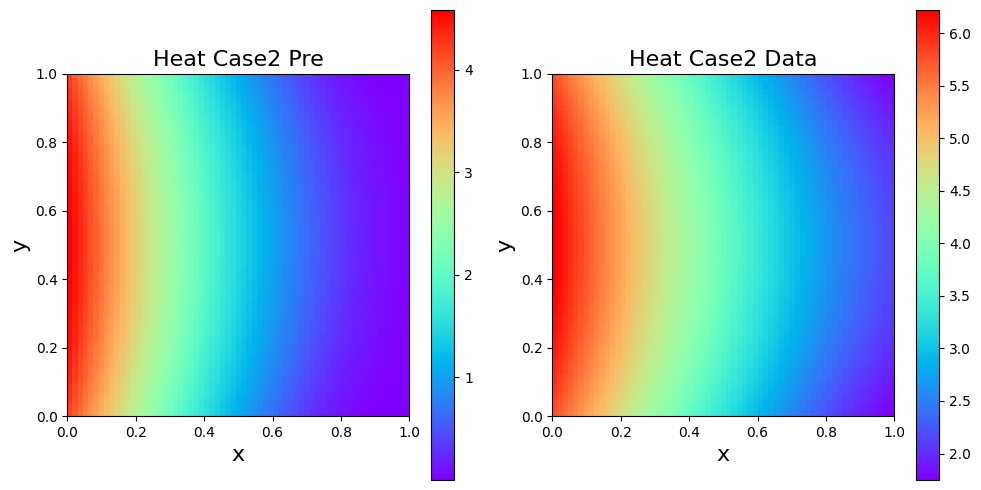

In [32]:
heat_data = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b2g1Dul/Heat-z3b2g1Dul.npy')
heat_data = heat_data[1:, ::2, ::2]
heat_pre = np.load('/root/radiation diffusion/TransNet/radiation diffusion/Heat-1T-z3b2g1Dul/Heat-z3b2g1Dul-tanh.npy')
heat_rl2 = dde.metrics.l2_relative_error(heat_data, heat_pre)
print("Heat Case2 rl2 : {:.4e}".format(heat_rl2))

vmin_pre = np.min(heat_pre[-1])
vmax_pre = np.max(heat_pre[-1])
norm_pre = colors.Normalize(vmin=vmin_pre, vmax=vmax_pre)
vmin_data = np.min(heat_data[-1])
vmax_data = np.max(heat_data[-1])
norm_data = colors.Normalize(vmin=vmin_data, vmax=vmax_data)
 
plt.figure(figsize=(10.0,5.0))
plt.subplot(121)
plt.imshow(heat_pre[-1], norm=norm_pre, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case2 Pre', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_pre[-1]), np.max(heat_pre[-1])])

plt.subplot(122)
plt.imshow(heat_data[-1], norm=norm_data, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case2 Data', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_data[-1]), np.max(heat_data[-1])])
plt.tight_layout()

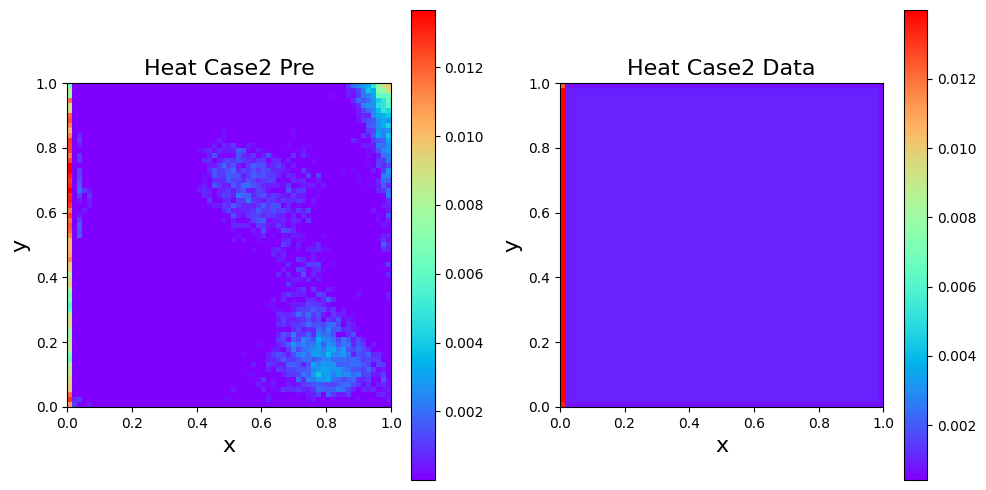

In [39]:
i = 1
vmin_pre = np.min(heat_pre[i])
vmax_pre = np.max(heat_pre[i])
norm_pre = colors.Normalize(vmin=vmin_pre, vmax=vmax_pre)
vmin_data = np.min(heat_data[i])
vmax_data = np.max(heat_data[i])
norm_data = colors.Normalize(vmin=vmin_data, vmax=vmax_data)
 
plt.figure(figsize=(10.0,5.0))
plt.subplot(121)
plt.imshow(heat_pre[i], norm=norm_pre, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case2 Pre', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_pre[i]), np.max(heat_pre[i])])

plt.subplot(122)
plt.imshow(heat_data[i], norm=norm_data, cmap=plt.get_cmap('rainbow'), extent=[0,1,0,1])
plt.title('Heat Case2 Data', fontsize=16)
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.colorbar()
plt.clim([np.min(heat_data[i]), np.max(heat_data[i])])
plt.tight_layout()